In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow.compat.v1 as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import csv
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [2]:
!kaggle datasets download -d hassanamin/textdb3

Dataset URL: https://www.kaggle.com/datasets/hassanamin/textdb3
License(s): GNU Lesser General Public License 3.0
 79% 9.00M/11.5M [00:01<00:00, 10.1MB/s]
100% 11.5M/11.5M [00:01<00:00, 7.47MB/s]


In [3]:
zip_ref = zipfile.ZipFile('/content/textdb3.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
data = pd.read_csv("fake_or_real_news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])

In [7]:
embedding_dim = 50
max_length = 54
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 3000
test_portion = .1

In [8]:
title = []
text = []
labels = []
for x in range(training_size):
    title.append(data['title'][x])
    text.append(data['text'][x])
    labels.append(data['label'][x])

In [9]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(title)
word_index1 = tokenizer1.word_index
vocab_size1 = len(word_index1)
sequences1 = tokenizer1.texts_to_sequences(title)
padded1 = pad_sequences(sequences1, padding=padding_type, truncating=trunc_type)
split = int(test_portion * training_size)
training_sequences1 = padded1[split:training_size]
test_sequences1 = padded1[0:split]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embeddings_index = {}
with open('glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size1+1, embedding_dim))
for word, i in word_index1.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

--2025-01-10 20:01:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-10 20:01:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-10 20:01:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size1+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         377,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 377,600 (1.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 377,600 (1.44 MB)

In [12]:
training_padded = np.array(training_sequences1)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences1)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels,
                    epochs=50,
                    validation_data=(testing_padded, testing_labels),
                    verbose=2)

Epoch 1/50
85/85 - 10s - 123ms/step - accuracy: 0.6363 - loss: 0.6437 - val_accuracy: 0.7067 - val_loss: 0.5754
Epoch 2/50
85/85 - 1s - 9ms/step - accuracy: 0.6904 - loss: 0.5768 - val_accuracy: 0.7167 - val_loss: 0.5245
Epoch 3/50
85/85 - 1s - 8ms/step - accuracy: 0.7359 - loss: 0.5321 - val_accuracy: 0.7267 - val_loss: 0.5357
Epoch 4/50
85/85 - 1s - 9ms/step - accuracy: 0.7681 - loss: 0.4924 - val_accuracy: 0.7300 - val_loss: 0.5020
Epoch 5/50
85/85 - 1s - 8ms/step - accuracy: 0.8011 - loss: 0.4303 - val_accuracy: 0.7367 - val_loss: 0.5460
Epoch 6/50
85/85 - 0s - 5ms/step - accuracy: 0.8074 - loss: 0.4273 - val_accuracy: 0.7533 - val_loss: 0.5020
Epoch 7/50
85/85 - 1s - 8ms/step - accuracy: 0.8452 - loss: 0.3560 - val_accuracy: 0.7567 - val_loss: 0.4926
Epoch 8/50
85/85 - 1s - 7ms/step - accuracy: 0.8600 - loss: 0.3279 - val_accuracy: 0.7533 - val_loss: 0.5068
Epoch 9/50
85/85 - 0s - 6ms/step - accuracy: 0.8781 - loss: 0.2909 - val_accuracy: 0.7267 - val_loss: 0.5828
Epoch 10/50
85/8

In [13]:
model.save("model.keras")

In [14]:
predictions = model.predict(testing_padded)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = testing_labels
class_labels = ["Fake", "Real"]
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'The accuracy of the model is: {accuracy:.4f}')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The accuracy of the model is: 0.7433
              precision    recall  f1-score   support

        Fake       0.72      0.77      0.74       144
        Real       0.77      0.72      0.74       156

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.75      0.74      0.74       300



In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

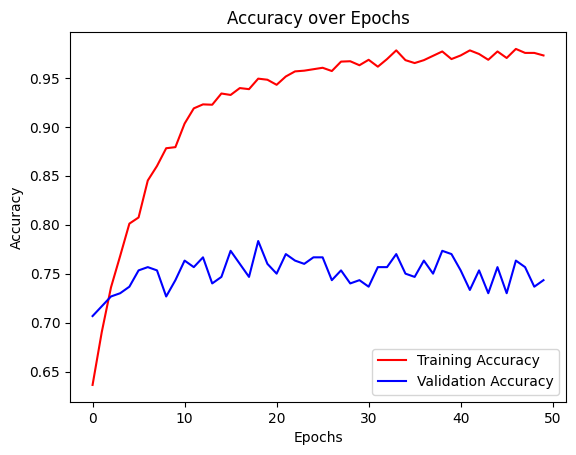

In [16]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

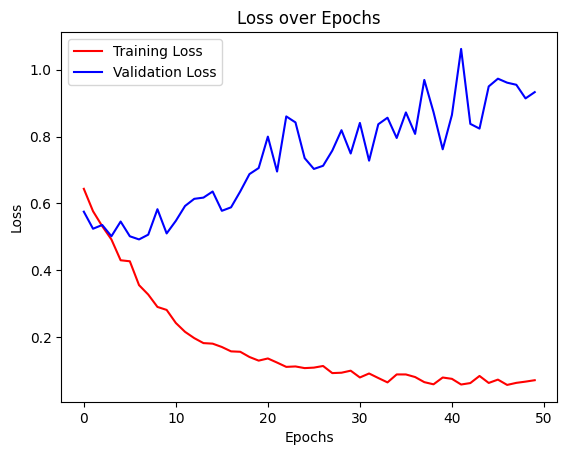

In [17]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [24]:
def check_news_validity(news):
    sequences = tokenizer1.texts_to_sequences([news])[0]
    sequences = pad_sequences([sequences], maxlen=54, padding=padding_type, truncating=trunc_type)
    if(model.predict(sequences, verbose=0)[0][0] >= 0.5):
        print("Real News")
    else:
        print("Fake News")

In [25]:
news = "Karry to go to France in gesture of sympathy"
check_news_validity(news)

Real News


In [26]:
news = "You Can Smell Hillary’s Fear"
check_news_validity(news)

Fake News
